# Beispiel 3.4

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr
from scipy.interpolate import PchipInterpolator
from scipy.stats import linregress

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
import pandas as pd

werbung = pd.read_csv("./Daten/Werbung.csv").drop(["Unnamed: 0"], axis=1)

werbung.head()
print(werbung.head())

      TV  Radio  Zeitung  Verkauf
0  230.1   37.8     69.2     22.1
1   44.5   39.3     45.1     10.4
2   17.2   45.9     69.3      9.3
3  151.5   41.3     58.5     18.5
4  180.8   10.8     58.4     12.9


In [4]:
with pm.Model() as model_lb:
    beta_0 = pm.Normal("beta_0", mu=0, sigma=100)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)
    sigma = pm.HalfCauchy("sigma", 10)
    mu = pm.Deterministic("mu", beta_0 + beta_1 * werbung.TV)
    y_pred = pm.Normal("y_pred", mu=mu, sigma=sigma, observed=werbung.Verkauf)
    idata_lb = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, sigma]


/opt/conda/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


- Es handelt sich um ein Modell für normalverteilte Daten, allerdings wird der Erwartungswert als eine lineare Funktion des TV-Werbebudgets modelliert. Der Achsenabschnitt ist $\beta_0$ und die Steigung ist $\beta_1$. Die Standardabweichung für das Rauschen ist $\sigma$ und der Erwartungswert ist $\mu$

- $\mu$ wird als `Deterministic` Variable definiert. Es handelt sich hier nicht um eine Zufallsvariable, sondern um eine deterministische Variable, welche aus dem Achsenabschnitt, der Steigung und dem TV-Werbebudget bestimmt wird. Wir definieren die Variable als `Deterministic`, da wir später in `InferenceData` darauf zurückgreifen möchten. Wir hätten auch einfach 

`mu = beta_0 + beta_1 * werbung.TV` oder 
` mu= pm.Normal(`y_pred`, mu=beta_0 + beta_1 * werbung.TV)` schreiben können. Das Modell wäre dasselbe gewesen, allerdings wird $\mu$ in diesem Fall nicht in `InferenceData` gespeichert 

- $\mu$ ist ein Vektor mit derselben Länge wie `werbung.TV`

Das Bayessche lineare Regressionsmodell für den Datensatz `Werbung`  ist in der folgenden Abbildung dargestellt:

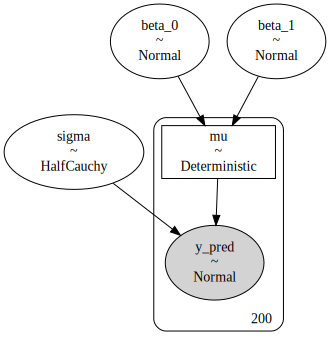

In [5]:
pm.model_to_graphviz(model_lb)
# Die Graphik kann gespeichert werden:
# gv = pm.model_to_graphviz(model_lb)
# gv.format = 'png'
# gv.render(filename='model_graph')

Mit dem folgenden Code können wir das Resultat unseres simulierten Bayesschen Regressionsmodells visualisieren:

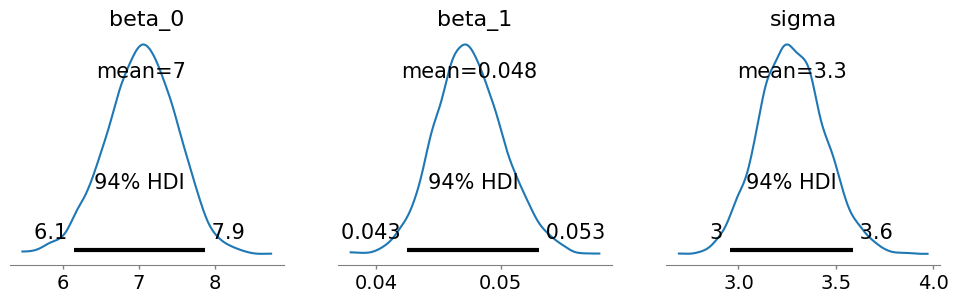

In [6]:
gv = az.plot_posterior(idata_lb, var_names=["~mu"], figsize=(12, 3))
fig = gv.ravel()[0].figure
# Die Graphik kann gespeichert werden 
# fig = gv.ravel()[0].figure
# fig.savefig(fname='posterior_mean_graph')

- Damit wir nicht für jeden Wert von `werbung.TV` einen Graphen generieren, spezifizieren wir mittels des Arguments `var_names=["~ mu"]`, dass wir die Variable $\mu$ ausschliessen (negieren). Alternativ könnten wir auch die Variablen, für welche wir einen Posterior Plot erstellen möchten, als Liste angeben: `var_names=["beta_0", "beta_1", "sigma"]`

Der obigen Abbildung entnehmen wir die Mittelwerte der Posterior-Verteilungen, und zwar für $\beta_0$ den Mittelwert 7, für $\beta_1$ den Mittelwert $0.048$ und für $\sigma$ den Mittelwert $3.3$. 

Die Posterior-Verteilungen informieren uns aber auch über die Unsicherheit bezüglich dieser Schätzungen. So ist das 94\% HDI für $\beta_0$ gegeben durch $[6.1, 7.9]$. Ohne Werbung liegt der Verkauf also zwischen $ 6100 $ und $ 7900 $ Einheiten.

Das 94\% HDI für $\beta_1$ ist $[0.043, 0.053]$. Für zusätzliche 1000CHF Ausgaben für das TV-Werbebudget würden wir im Schnitt zwischen 43 und 53 zusätzliche Einheiten des Produktes verkaufen. 

Wir müssen allerdings noch berücksichtigen, dass dies nur die Unsicherheit des Erwartungswertes der verkauften Produkt-Einheiten ist. Zusätzlich haben wir ja noch die Unsicherheit aufgrund von $\sigma$. Wir erwarten bei einem TV-Werbebudget von 120000 CHF den Verkauf von 12760 Einheiten des Produktes. Selbst wenn wir die Unsicherheit von $\mu$ vernachlässigen, wären wir aufgrund von $\sigma$ aber nicht überrascht, falls es dann nur $12760-3300=9460$ oder sogar $12760+3300=16060$ Einheiten sind.